# Provide real demand from data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from MaaSSim.data_structures import structures as inData
from MaaSSim.utils import load_G, get_config, prep_supply
from osmnx.distance import nearest_nodes, great_circle_vec
import osmnx as ox

One day of data from our BQ for `Barcelona, Spain` and config:

In [3]:
import pandas as pd
df = pd.read_csv("../../data/Bordaux.csv")
params = get_config('../../data/config/bordaux.json')  # load configuration
params.nV = 10  # and vehicle supply number
inData = load_G(inData, params)  # load city network graph 

/Users/andrzej/Personal/MaaSSim/MaSSim/lib/python3.8/site-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [4]:
df.head(5)

,trip_id,correlation_id,origin_city,destination_city,booking_time,date_scheduled,fleet_id,vehicle_latitude,vehicle_longitude,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,event_timestamp
0,c19217bb-6531-4418-969e-861881d6ed9a,7e1f3b24-588a-4037-b9cc-10de5a673719,Bordeaux,Bordeaux,2021-07-09 07:35:05 UTC,2021-09-08 16:58:00 UTC,322ad7b9-f077-4036-91ec-8d096d3e861a,44.822,-0.568,44.826,-0.557,44.889,-0.566,2021-07-09 07:35:59.564586 UTC
1,c19217bb-6531-4418-969e-861881d6ed9a,GENERATED_4f23c1c8-9dcd-4875-9a0f-477ffc653525,Bordeaux,Bordeaux,2021-07-09 07:35:05 UTC,2021-09-08 16:58:00 UTC,322ad7b9-f077-4036-91ec-8d096d3e861a,44.822,-0.568,44.826,-0.557,44.889,-0.566,2021-07-09 07:35:59.735556 UTC
2,c7c564d9-21f4-4d19-9b36-642e66ade5c3,aa933df5-18eb-4755-b2db-4f63b88c3afb,Bordeaux,Bruges,2021-07-09 07:40:03 UTC,2021-07-09 10:01:00 UTC,322ad7b9-f077-4036-91ec-8d096d3e861a,44.859,-0.567,44.826,-0.557,44.877,-0.596,2021-07-09 07:43:26.871805 UTC
3,c7c564d9-21f4-4d19-9b36-642e66ade5c3,5f2c34f5-dd33-4907-8d26-2e28a166e052,Bordeaux,Bruges,2021-07-09 07:40:03 UTC,2021-07-09 10:01:00 UTC,322ad7b9-f077-4036-91ec-8d096d3e861a,44.859,-0.567,44.826,-0.557,44.877,-0.596,2021-07-09 08:43:28.615635 UTC
4,9d89881c-f185-4db3-ab74-c86b889190b6,6e008443-8781-4559-bc54-96c645f6ff51,Bordeaux,Bordeaux,2021-07-02 15:01:00 UTC,2021-07-09 13:00:00 UTC,322ad7b9-f077-4036-91ec-8d096d3e861a,44.815,-0.580,44.824,-0.581,44.826,-0.557,2021-07-09 11:00:00.483215 UTC


In [20]:
df["pickup_point"] = nearest_nodes(inData.G, df.pickup_longitude, df.pickup_latitude)
df["dropoff_point"] = nearest_nodes(inData.G, df.dropoff_longitude, df.dropoff_latitude)

In [21]:
df["vehicle_point"] = nearest_nodes(inData.G, df.vehicle_longitude, df.vehicle_latitude)

In [22]:
params.nP = 150
df = df.sample(params.nP) # restrict it for demo
df.reset_index(drop=True, inplace=True)
df.head(2)

,trip_id,correlation_id,origin_city,destination_city,booking_time,date_scheduled,fleet_id,vehicle_latitude,vehicle_longitude,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,event_timestamp,pickup_point,dropoff_point,vehicle_point
0,d84afa1d-d83c-411c-a8a9-316eb0aa0648,824bcb30-6dc1-4fc5-8988-6bbba3ae7252,Bordeaux,Mérignac,2021-10-25 14:26:30 UTC,2021-10-28 03:50:00 UTC,322ad7b9-f077-4036-91ec-8d096d3e861a,44.801,-0.552,44.831,-0.596,44.832,-0.702,2021-10-25 14:28:51.487033 UTC,250601762,3350732739,283034240
1,350278ad-d30e-45ff-b2e0-0fd6ed12953f,b7758c72-d4f9-4138-a056-77544b11f041,Bordeaux,Bouliac,2021-08-29 13:22:37 UTC,2021-08-29 14:35:00 UTC,322ad7b9-f077-4036-91ec-8d096d3e861a,44.822,-0.568,44.826,-0.557,44.829,-0.491,2021-08-29 13:23:58.751253 UTC,2485066424,4757870396,282206022


Mock a platforms for now (this can be different fleets in future)

In [23]:
inData.platforms.fare = [1]
inData.platforms.name = "platform_name"
inData.platforms.batch_time = 1

In [24]:
inData.passengers.pos = df["pickup_point"]
inData.passengers.platforms = [[0]] * len(inData.passengers)
inData.passengers = inData.passengers.dropna(subset=["pos"])
inData.passengers.index = df.index
len(inData.passengers)

150

In [25]:
inData.passengers.sample(10)

,pos,event,platforms
67,2485066424,NaN,[0]
105,2485066424,NaN,[0]
139,2485066424,NaN,[0]
62,2485066424,NaN,[0]
24,255272065,NaN,[0]
82,2485066424,NaN,[0]
14,2485066424,NaN,[0]
66,2485066424,NaN,[0]
122,2485066424,NaN,[0]
144,2485066424,NaN,[0]


Real user positions from our quote data:

In [26]:
inData = prep_supply(inData, params)  # generate supply (mocking the vehicles)

In [35]:
inData.vehicles.pos = df.sample(params.nV+1).reset_index()['vehicle_point']

In [36]:
inData.requests = inData.requests.dropna()

Mock requests (it can be real requests in the future)

In [37]:
inData.requests.pax_id = inData.passengers.index
inData.requests.origin = inData.passengers.pos
inData.requests.destination = df["dropoff_point"]
inData.requests.treq = pd.to_datetime(df["booking_time"]).dt.tz_localize(None)
inData.requests.tarr = pd.to_datetime(df["date_scheduled"]).dt.tz_localize(None)
inData.requests.ttrav = pd.to_timedelta(inData.requests.tarr - inData.requests.treq)
inData.requests["platform"] = [[0]] * len(inData.passengers.index)
inData.requests["dist"] = round(great_circle_vec(df["pickup_longitude"], df["pickup_latitude"], df["dropoff_longitude"], df["dropoff_latitude"]))

In [38]:
inData.requests.head()

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,platform,dist
0,0,250601762,3350732739,2021-10-25 14:26:30,NaN,2 days 13:23:30,2021-10-28 03:50:00,NaN,NaN,NaN,[0],11787.0
1,1,2485066424,4757870396,2021-08-29 13:22:37,NaN,0 days 01:12:23,2021-08-29 14:35:00,NaN,NaN,NaN,[0],7346.0
2,2,2485066424,2507541750,2021-08-31 17:12:03,NaN,29 days 23:53:57,2021-09-30 17:06:00,NaN,NaN,NaN,[0],2678.0
3,3,2485066424,836858367,2021-08-08 12:10:26,NaN,40 days 13:49:34,2021-09-18 02:00:00,NaN,NaN,NaN,[0],12454.0
4,4,2485066424,308756431,2021-07-26 17:53:33,NaN,6 days 15:14:27,2021-08-02 09:08:00,NaN,NaN,NaN,[0],16261.0


In [39]:
params.nP = len(inData.requests)

In [40]:
params.paths.get('requests', False)

False

In [41]:
params.times.patience = 1000
params.times.pickup_patience = 1000
params.simTime = 72

In [42]:
from MaaSSim.simulators import simulate
sim = simulate(params = params, inData = inData, config='../../data/config/bordaux.json') # simulate

12-11-21 11:48:06-WARNING-Setting up 72h simulation at 2021-05-07 17:22:59 for 10 vehicles and 150 passengers in Eysines, France
12-11-21 11:48:14-INFO--------------------	Starting simulation	-------------------
12-11-21 11:48:14-INFO-pax   34  got to dest at                           2021-05-07 17:36:45
12-11-21 11:48:14-INFO-pax  148  got to dest at                           2021-05-07 17:51:46
12-11-21 11:48:14-INFO-pax   52  got to dest at                           2021-05-07 17:53:22
12-11-21 11:48:14-INFO-pax  105  got to dest at                           2021-05-07 17:57:17
12-11-21 11:48:14-INFO-pax  104  got to dest at                           2021-05-07 17:57:29
12-11-21 11:48:14-INFO-pax   35  got to dest at                           2021-05-07 18:14:25
12-11-21 11:48:14-INFO-pax    4  got to dest at                           2021-05-07 18:17:24
12-11-21 11:48:14-INFO-pax   81  got to dest at                           2021-05-07 18:17:24
12-11-21 11:48:14-INFO-pax   43  got

In [43]:
inData.vehicles.sample(5)

,pos,event,shift_start,shift_end,platform,expected_income
veh,,,,,,
1,2.798114e+08,driverEvent.ENDS_SHIFT,0,86400,0,NaN
4,3.350733e+09,driverEvent.ENDS_SHIFT,0,86400,0,NaN
6,2.507542e+09,driverEvent.ENDS_SHIFT,0,86400,0,NaN
5,2.889517e+08,driverEvent.ENDS_SHIFT,0,86400,0,NaN
10,2.507542e+09,driverEvent.ENDS_SHIFT,0,86400,0,NaN


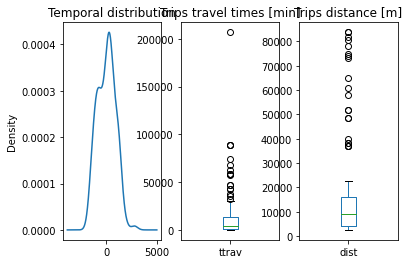

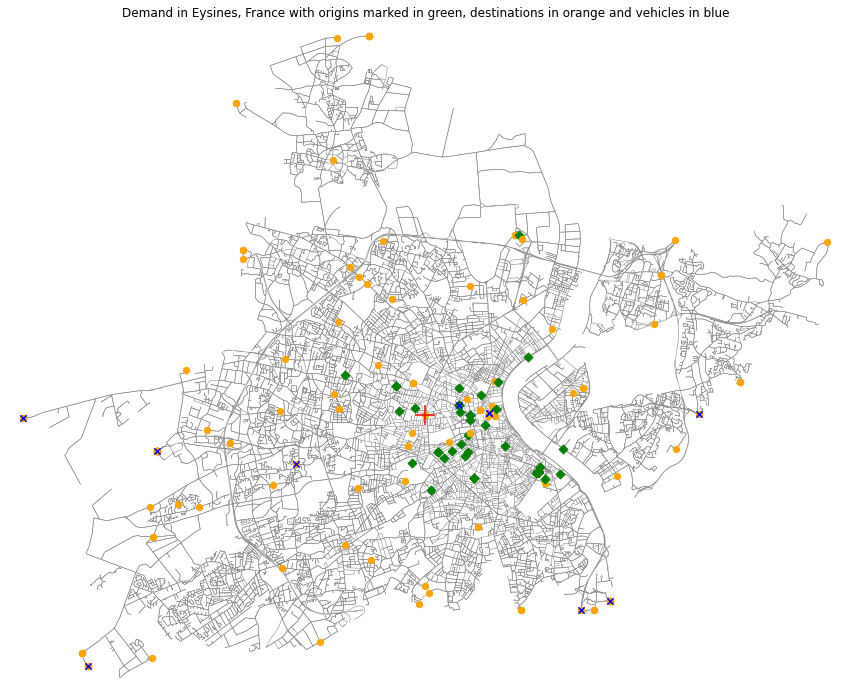

In [44]:
from MaaSSim.visualizations import plot_demand
plot_demand(inData, vehicles = True, s = 40, params = params)

In [45]:
trip_id  = 102 # we inspext traveller 6
req = sim.inData.requests[sim.inData.requests.pax_id==trip_id].squeeze() # this is his ride request
aggr = sim.res[0].pax_exp.loc[trip_id] # this is his aggregated results 
raw = sim.runs[0].trips[sim.runs[0].trips.pax == trip_id]  # this is his record within simulation
req.to_frame().T

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,platform,dist,ride_id,position,sim_schedule
102,102,2485066424,4574099863,2021-08-24 19:50:15,NaN,1 days 00:55:45,2021-08-25 20:46:00,NaN,False,NaN,[0],8982,102,0,node time req_id od 0 ...


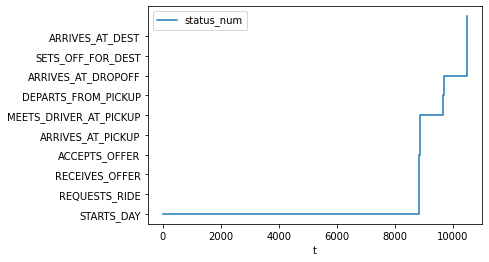

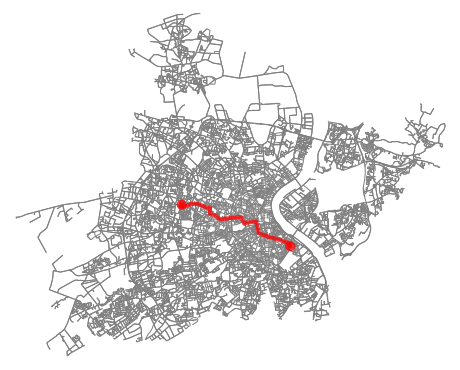

In [46]:
sim.plot_trip(trip_id)

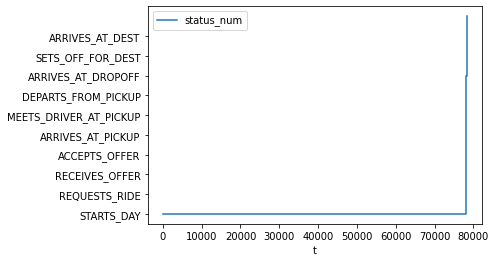

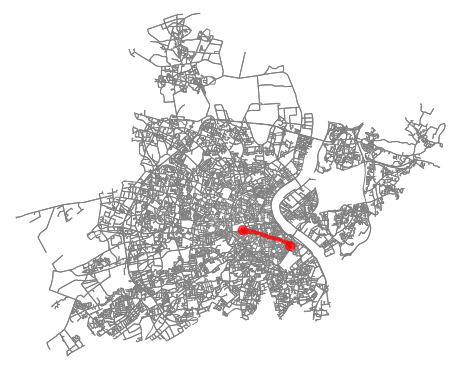

In [47]:
trip_id  = 108 # we inspext traveller 10
req = sim.inData.requests[sim.inData.requests.pax_id==trip_id].squeeze() # this is his ride request
aggr = sim.res[0].pax_exp.loc[trip_id] # this is his aggregated results 
raw = sim.runs[0].trips[sim.runs[0].trips.pax == trip_id]  # this is his record within simulation
req.to_frame().T
sim.plot_trip(trip_id)

In [51]:
res = sim.runs[0]

In [52]:
import folium
import json
import h3
from geojson.feature import Feature, FeatureCollection
from shapely.geometry import Point, Polygon, LineString
phantom_path = '/usr/local/bin/phantomjs'

def plot_hex_wait_vehs(inData, res, APERTURE_SIZE = 9, threshold = 3, col = 'wait_time'):
       
    traces = res.rides[['veh','pos','t']]
    diffs = traces.diff()
    diffs.columns = [_+"_diff" for _ in diffs.columns]
    traces = pd.concat([traces, diffs], axis = 1)
    trips = traces[(traces.veh_diff==0) & (traces.pos_diff==0)][['pos','t_diff']]
    trips.columns = ['pos','wait_time']
    trips['x'] = trips.apply(lambda row: inData.nodes.loc[row.pos].x if row.pos in inData.nodes.index else 0, axis = 1)
    trips['y'] = trips.apply(lambda row: inData.nodes.loc[row.pos].y if row.pos in inData.nodes.index else 0, axis = 1)
    trips['hex_o_{}'.format(APERTURE_SIZE)] = trips.apply(lambda row: h3.geo_to_h3(row.y,row.x,APERTURE_SIZE),axis = 1) 
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(list(trips[col_geom].unique())+list(trips[col_geom].unique())))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = trips.groupby(col_geom).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)
    aggr = trips.groupby(col_geom)[col]
    hexes['nobs'] = aggr.size()
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": APERTURE_SIZE})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=13,tiles=tile, zoomControl =  False)
    bins = [0, 1, 2, 3, 5, 10, 15, 20, 25, 2000]
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",
            fill_color='Blues', control = False, bins = bins,
            fill_opacity=0.7, line_opacity=0.1).add_to(base_map)
    return base_map

plot_hex_wait_vehs(inData, res, APERTURE_SIZE = 8)

In [53]:
import numpy as np

results = sim.res[0]
res = sim.runs[0]

def plot_hex_map(inData, res, results, APERTURE_SIZE = 9, threshold = 3, col = 'wait_time'):
    res.requests['wait_time'] = results.pax_exp.WAIT
    res.requests['x'] = inData.nodes.loc[inData.passengers.pos].x.values
    res.requests['y'] = inData.nodes.loc[inData.passengers.pos].y.values
    res.requests['hex_o_{}'.format(APERTURE_SIZE)] = []
    for row in zip(res.requests['y'], res.requests['x']): 
        res.requests['hex_o_{}'.format(APERTURE_SIZE)].append(h3.geo_to_h3(row[0],row[1],APERTURE_SIZE))
    
    trips = res.requests
    
    col_geom = 'hex_o_{}'.format(APERTURE_SIZE)
    hexes = pd.Series(list(set(trips[col_geom]))).to_frame(col_geom)
    hexes = hexes.set_index(col_geom)
    hexes[col_geom] = hexes.index.copy()
    hexes['nobs'] = pd.DataFrame(trips[col_geom]).groupby([0]).size()
    hexes = hexes[hexes['nobs']>threshold]
    hexes['geom'] = hexes.apply(lambda x: {"type": "Polygon","coordinates": [h3.h3_to_geo_boundary(h = x[col_geom], geo_json = True)]}, axis = 1)

    aggr = pd.DataFrame(np.array([res.requests[col_geom], res.requests["wait_time"]]).T, columns=[col_geom, col])
    aggr[col] = pd.to_numeric(aggr[col])
    aggr = aggr.groupby([col_geom])[col]
    
    hexes['nobs'] = aggr.size()
    
    hexes[col] = aggr.mean()/60
    hexes[col+'_std'] = aggr.std()
    list_features = []
    for i, row in hexes.iterrows():
        feature = Feature(geometry = row["geom"],
                          id = row[col_geom],
                          properties = {"resolution": APERTURE_SIZE})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_hexes = json.dumps(feat_collection)
    CENTER = list(inData.nodes.loc[inData.stats.center][['y','x']].values)
    tile = 'cartodbpositron'
    base_map = folium.Map(location=CENTER, zoom_start=10,tiles=tile, zoomControl =  False)
    bins = [0, 1, 2, 3, 5, 10, 15, 20, 25, 2000]
    m = folium.Choropleth(geo_data = geojson_hexes,data = hexes, columns = [col_geom,col],key_on ="feature.id",
            fill_color='Blues', control = False, bins = bins,
            fill_opacity=0.7, line_opacity=0.1).add_to(base_map)
    return base_map
    
plot_hex_map(inData, res, results, APERTURE_SIZE = 8)
